In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import arviz as az
import pymc3 as pm

In [2]:
az.style.use('arviz-white')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelos lineales</h1>



<br>
<br>
<br>
<br>
<br>

## Objetivos

* Introducir el concepto de modelo lineal

## Regresión lineal

<br>

* Tenemos una variable $x$, y a partir de esta queremos predecir o modelar una variable $y$. 


* Además, estás variables se encuentran apareadas $\{(x_1,y_1), (x_2,y_2), (x_3,y_3),\dots (x_n,y_n)\} $.


* En el caso más simple $x$ e $y$ son variables aleatorias continuas y unidimensionales.


* Hay varios nombres para $y$, variable dependiente, predicha o respuesta. Mientras que $x$ recibe nombres como variable independiente, predictora o *de entrada*

## Regresión lineal

<br>


* En *Machine learning* es común hablar de *features* en vez de variables y es común pensar que una regresión lineal es un ejemplo de [aprendizaje supervisado](https://es.wikipedia.org/wiki/Aprendizaje_supervisado).


* Cuando tenemos más de una variable independiente agrupar los datos en una matriz $X$ (usualmente llamada [matriz de diseño](https://en.wikipedia.org/wiki/Design_matrix)), donde por lo general las columnas representan distintos tipos de variables (o *features*) y las filas contienen las instancias o individuos.


* Este tipo de modelo se llama regresión lineal múltiple o regresión lineal multivariable y es quizá el caso más común de regresión lineal.


* El nombre regresión lineal multivariada debería reservarse a casos en que tenemos más de una variable respuesta, aunque es muy común en literatura que estos términos se confundan.

## El modelo lineal

$$y_i = \alpha + x_i \beta $$


* $\beta$ controla la pendiente en la relación lineal y, por lo tanto, podemos interpretarlo como el cambio en la variable $y$ por cambio de unidad en la variable $x$. 

* El parámetro $\alpha$ se conoce como intercepto u ordenada al origen, y podemos interpretarlo como el valor de $y_i$ cuando $x_i = 0$. 

* Gráficamente, $\alpha$ indica el valor de $y_i$ donde la línea intercepta al eje y.

## Interpretación probabilista

<br>


$$y \sim \mathcal{N}(\mu=\alpha + x \beta, \epsilon)$$


<br>

* Es decir $y$ es una variable aleatoria distribuida según una Gaussiana con media $\alpha + x \beta$ desviación estándar $\epsilon$.


* Desde esta perspectiva una regresión lineal es una extensión de un modelo Gaussiano donde en vez de estimar la media de forma directa la calculamos como una una función lineal de las variables predictoras.


## A Prioris en regresión lineal

Asumiendo que $\alpha$, $\beta$ y $\epsilon$ son desconocidos debemos asignarles distribuciones _a priori_. Una elección razonable y genérica sería:

$$
\alpha \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon \sim |\mathcal{N}(0, \sigma_\epsilon)| 
$$


Si usáramos *a prioris planos* entonces el valor del _máximo a posteriori_ (la moda del posterior) sería el mismo que el encontrado usando *maximum likelihood/mínimos cuadrados*. 

In [6]:
np.random.seed(1)
N = 100
α_real = 2.5
β_real = 0.9
ϵ_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = α_real + β_real * x 
y = y_real + ϵ_real

# Podemos centrar los datos
#x = x - x.mean()
# o podemos estandarizarlos
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

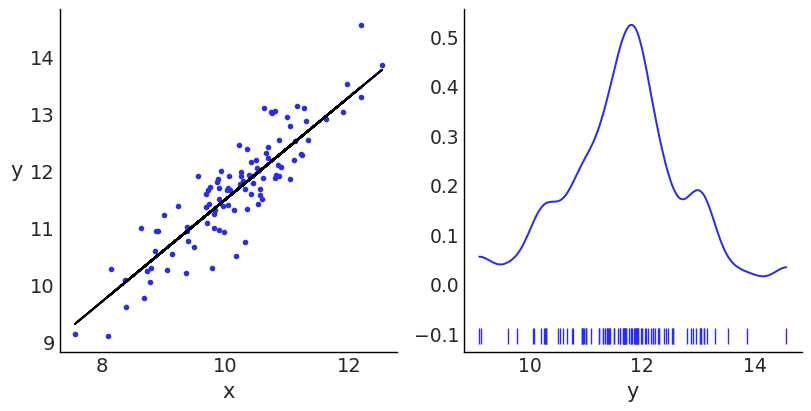

In [7]:
_, ax = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0, labelpad=10)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1], rug=True)
ax[1].set_xlabel('y');

In [8]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)

    ϵ = pm.HalfNormal('ϵ', 5)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


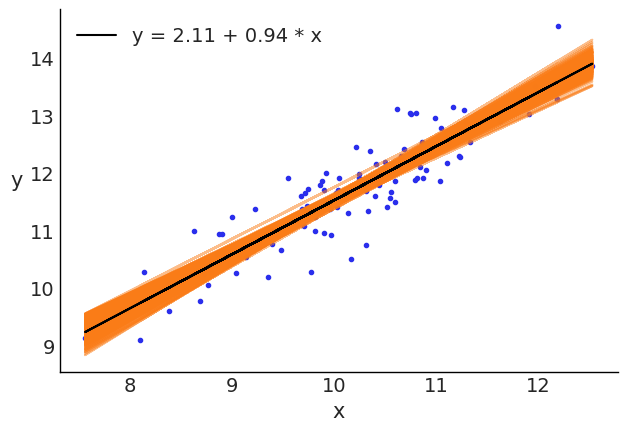

In [9]:
plt.plot(x, y, 'C0.')

α_m = trace_g['α'].mean()
β_m = trace_g['β'].mean()

idx = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][idx] + trace_g['β'][idx] *  x[:,np.newaxis], c='C1', alpha=0.5);

plt.plot(x, α_m + β_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=10)
plt.legend();

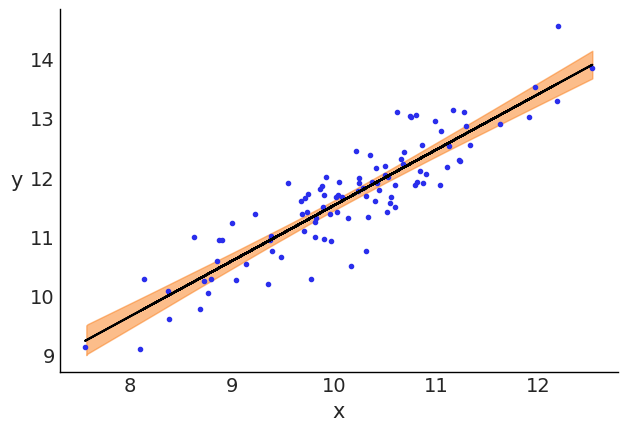

In [10]:
plt.plot(x, y, 'C0.')

plt.plot(x, α_m + β_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

az.plot_hpd(x, trace_g['μ'], color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0, labelpad=10);

In [11]:
ppc = pm.sample_posterior_predictive(trace_g, samples=4000, model=model_g)

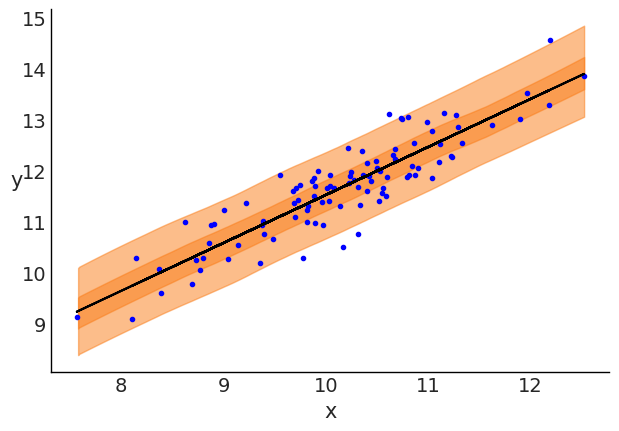

In [12]:
plt.plot(x, y, 'b.')
plt.plot(x, α_m + β_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

az.plot_hpd(x, ppc['y_pred'], color='C1')
az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0);

## Regresión lineal robusta

<br>
<br>

<center><img src="../img/outlier.png" width="750">


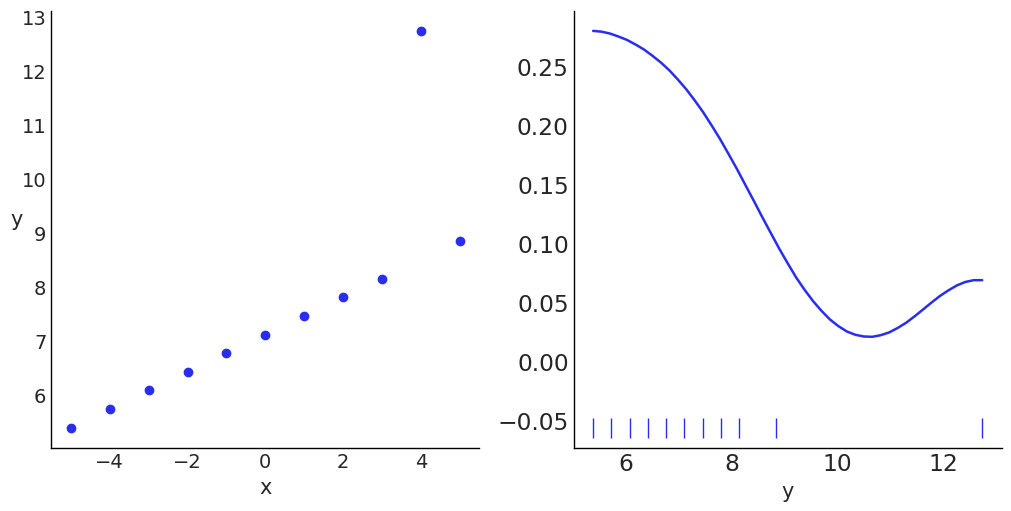

In [13]:
ans = pd.read_csv('../datos/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()


_, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)

ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x',)
ax[0].set_ylabel('y', rotation=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y');

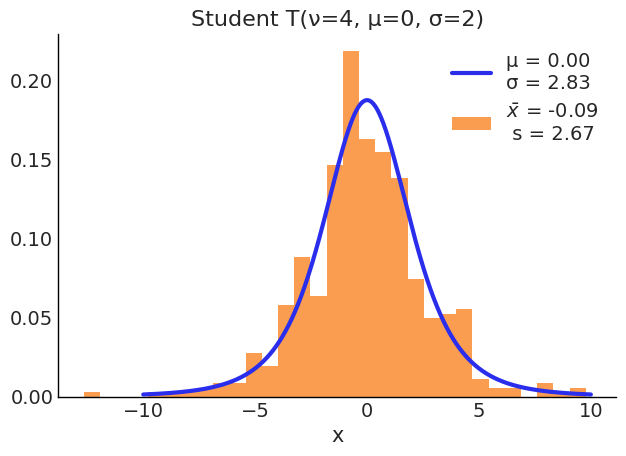

In [14]:
μ = 0  # Media
σ = 2  # Escala
ν = 4 # normalidad/grados de libertad
distri = stats.t(loc=μ, scale=σ, df=ν)
x = np.linspace(-10, 10, 2000)
x_rvs = distri.rvs(500)  # muestrear 500 valores de la distribución
x_pdf = distri.pdf(x)  # la pdf evaluada para todos los x
mean, variance = distri.stats(moments='mv')
plt.plot(x, x_pdf, lw=3,
         label=f'μ = {mean:3.2f}\nσ = {variance**0.5:3.2f}')
plt.hist(x_rvs, bins='auto', density=True,
         label=f'$\\bar x$ = {x_rvs.mean():3.2f}\n s = {x_rvs.std():3.2f}', alpha=0.75)

plt.xlabel('x')
plt.legend()
plt.title(f'Student T(ν={ν}, μ={μ}, σ={σ})');

In [15]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]


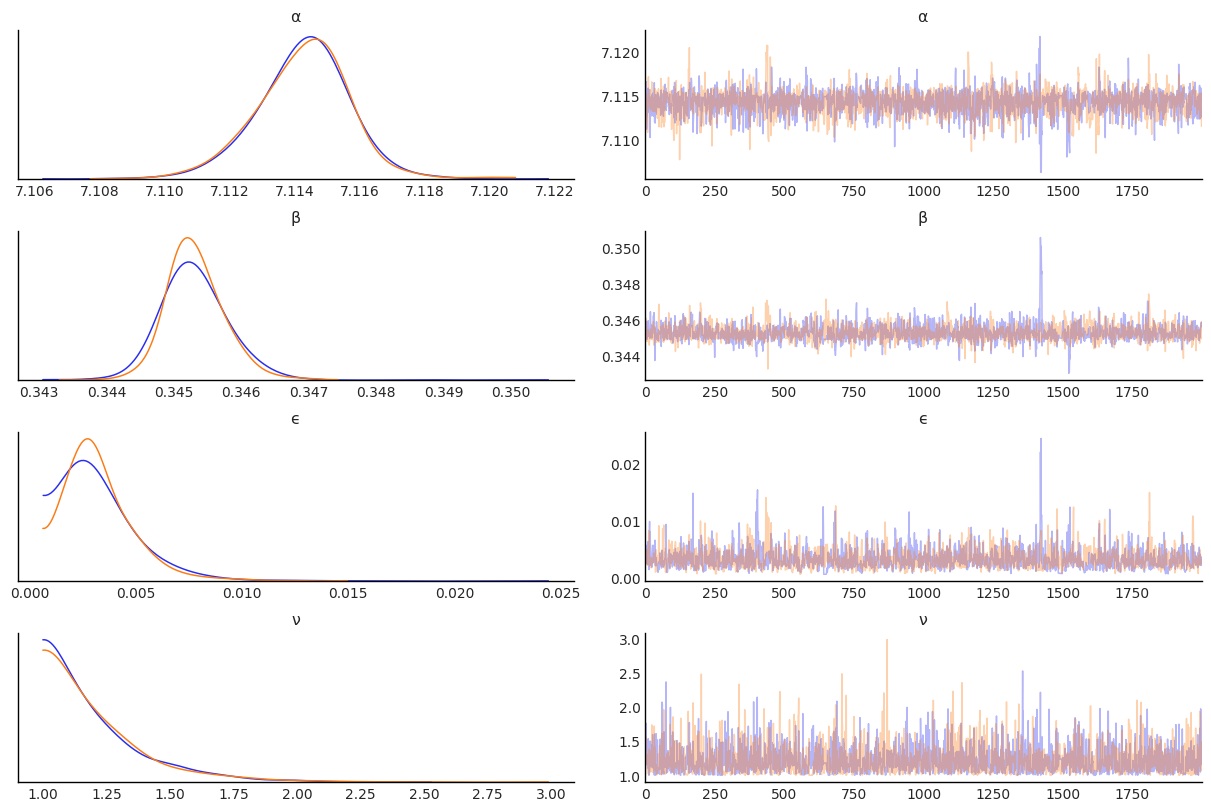

In [16]:
az.plot_trace(trace_t, var_names='~ν_');

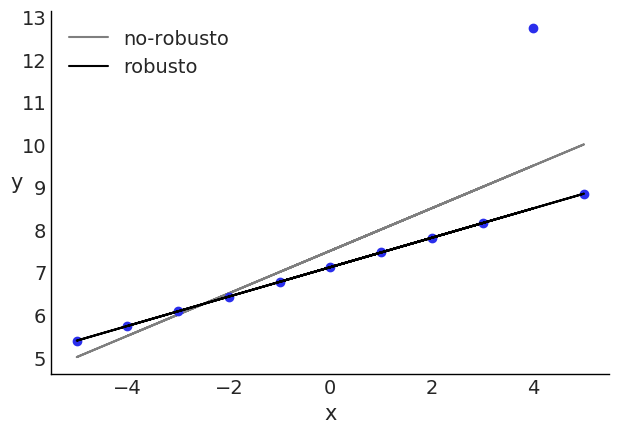

In [17]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]  # mínimos cuadrados

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='no-robusto', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robusto')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2);

In [18]:
az.summary(trace_t, var_names='~ν_')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.111,7.117,0.000,0.000,2324.0,2324.0,2506.0,1936.0,1.0
β,0.345,0.000,0.345,0.346,0.000,0.000,1334.0,1331.0,1898.0,1672.0,1.0
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,1410.0,1339.0,1305.0,1070.0,1.0
ν,1.209,0.207,1.000,1.594,0.004,0.003,3318.0,3318.0,1966.0,1369.0,1.0


## Regresión lineal jerárquica

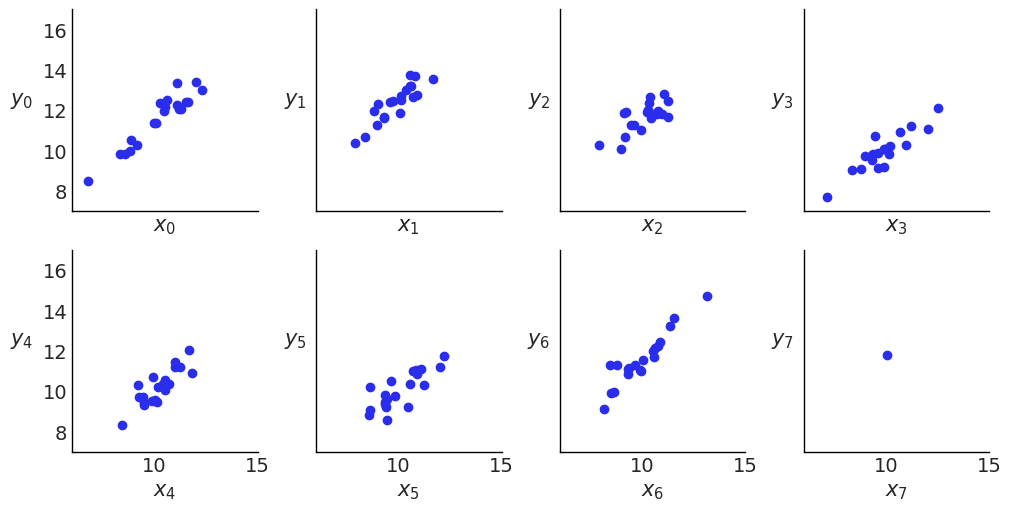

In [19]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alfa_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alfa_real[idx] + beta_real[idx] * x_m  + eps_real

_, ax = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

In [20]:
x_centered = x_m - x_m.mean()

In [21]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ = pm.Normal('α_μ', mu=0, sd=10)
    α_σ = pm.HalfNormal('α_σ', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ, sd=α_σ, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfNormal('ϵ', 10)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered, sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean()) 
    
    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ, α_μ]


There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


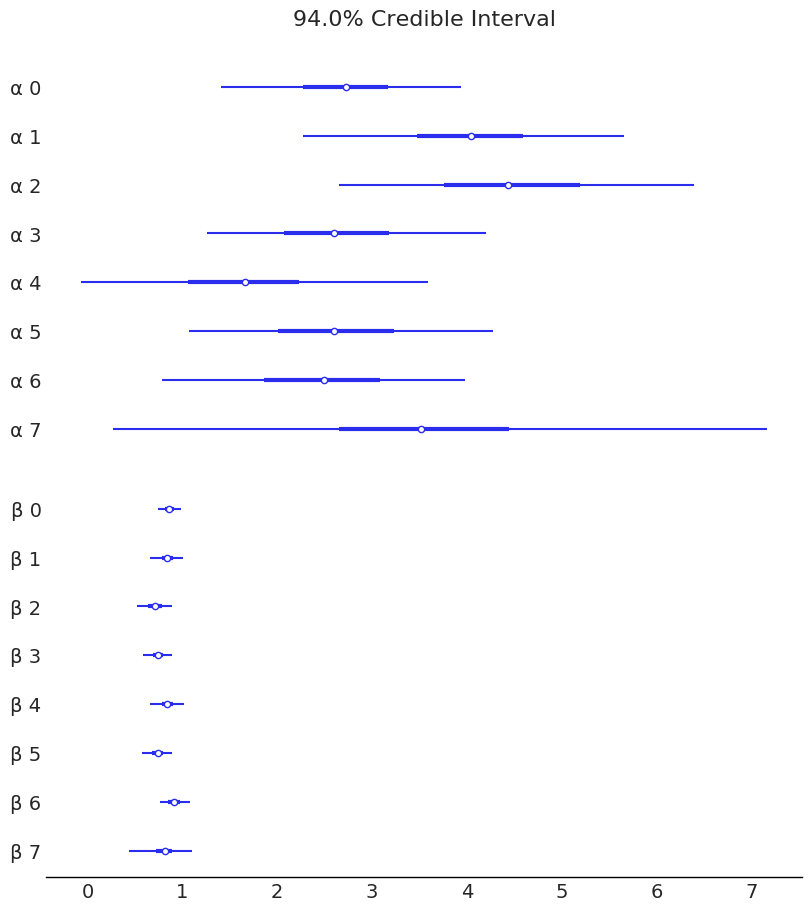

In [22]:
az.plot_forest(trace_hm, var_names=['α', 'β'], figsize=(8, 9), combined=True, r_hat=False, ess=False);

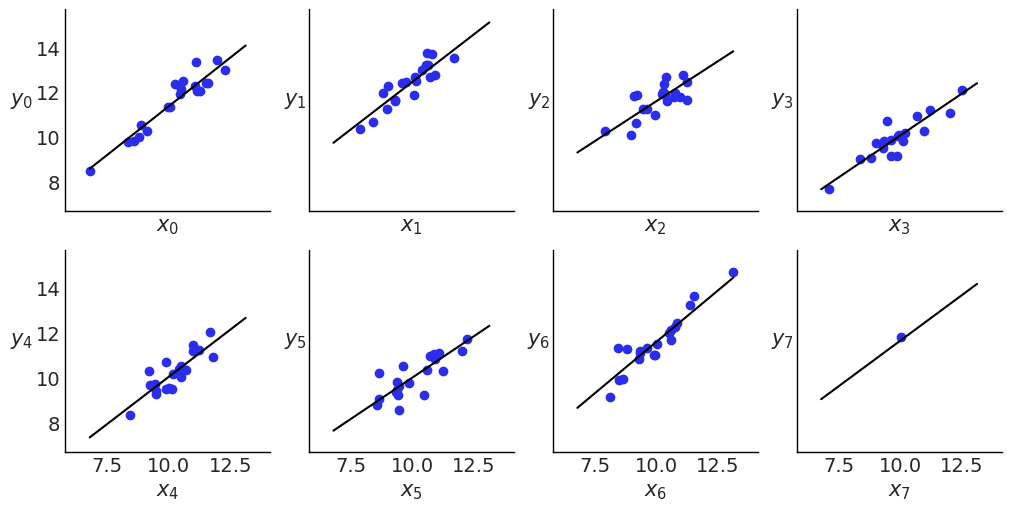

In [44]:
# add uncertainty
_, ax = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel('$x_{}$'.format(i))
    ax[i].set_ylabel('$y_{}$'.format(i), labelpad=10, rotation=0)
    alfa_m = trace_hm['α'][:,i].mean()
    beta_m = trace_hm['β'][:,i].mean()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N